## Exercício.
##### Autor
* Junior Guedes dos Santos
* 18/11/2022 01h40m AM

##### Instação de dependências:
* pip install tensorflow-datasets
* pip install tfds-nightly
* pip install --upgrade tensorflow-hub

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

import tensorflow_datasets as tfds

### DATASET
O conjunto de dados é fornecido gratuitamente pelo Google, por meio do codebase TensorFlow, através da biblioteca tfds.
Dentre os vários conjuntos disponíveis, foi escolhido o dataset Flowers, cujos os dados são de flores.

In [3]:
(train_ds, val_ds, test_ds, unlabelled_ds), metadata = tfds.load(
    "tf_flowers",
    split=["train[:1000]", "train[1000:1500]", "train[1500:2500]", "train[2500:]"],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


### Preprocessamento
Antes de realizar os treinamentos é necessário fazer um preprocessamento do dataset. Em particular, iremos redefinir o tamanho de todas as imagens para 299x299 pixels. Isso contribuirá para um trinamento mais rápido.
Deve-se considerar a utilização desse mesmo tamanho de imagens ao realizar as inferências e avaliações.

In [4]:
resizing_layer = tf.keras.layers.Resizing(299, 299)

In [5]:
def preprocess_images(dataset):
    ds = dataset.cache()
    ds = ds.map(lambda x, y: (resizing_layer(x), y))
    ds = ds.map(lambda x, y: (x / 255.0, y))
    return ds


def batch_dataset(dataset):
    ds = dataset.batch(100)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [6]:
# Épocas de treinamento nos dois modelos
epochs = 10

In [7]:
# As referências abaixo retornam as imagens redimensionadas (preprocessamento)
preprocessed_train_ds = preprocess_images(train_ds)
train_ds = batch_dataset(preprocessed_train_ds)
val_ds = batch_dataset(preprocess_images(val_ds))
test_ds = batch_dataset(preprocess_images(test_ds))
unlabelled_ds = preprocess_images(unlabelled_ds)

### Modelo Pretreinado
Considerando o tempo demora que é para realizar um treinamento efetivo de um modelo e sabendo que pode levar semanas para o treinamento eficiente, então escolhi um modelo pretreinado a fim de que eu possa apenas realizar uma transferência de aprendizagem.

Assim, o modelo escolhido foi o **InceptionV3** publicado pelo Google. O objetivo é fazer uma transferência de aprendizagem, já que o modelo foi treinado com espécies de flores que são dados similares ao treinados aqui.

**IMPORTANTE:** 
Ao rodar os treinos, observei que um modelo pretreinado estava tendo um treino equivalente ao utilizar as técnicas de Active Learning. Caso queira utilizar o modelo pretreinado basta descomentar as linhas superiores do bloco abaixo e  comentar as linhas inferiores.

In [8]:
# O modelo tem a sua propriedade trainable definida para false, uma vez que eu quero congelar o modelo interno.
# Primeiro é treinado o novo topo de camadas densas, depois é descongelado o modelo para realizar o refinamento (fine-tuning)
#model = tf.keras.Sequential(
#    [
#        hub.KerasLayer(
#            "https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/5",
#            trainable=False,
#        ),
#        tf.keras.layers.Dense(5), # 5 Classes de flores
#    ]
#)

model = tf.keras.Sequential()
model.add(Conv2D(32, (3, 3), padding="same", input_shape=(299, 299, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5))

model.build([None, 299, 299, 3]) 

In [9]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [10]:
# Primeiro é treinado a camada densa contida no topo por 2 épocas.
#model.fit(train_ds, validation_data=val_ds, epochs=2)

# Descongelando o modelo
#model.trainable = True

# Depois o modelo é treinado inteiramente por N épocas "epochs"
# Neste caso, assim como comentei nos blocos anteriores, considerei utilizar um modelo criado do zero através do Keras, por essa razão as linhas anteriores foram comentadas
history_1 = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
10/10 [==============================] - 12s 103ms/step - loss: 5.4715 - accuracy: 0.2450 - val_loss: 1.4598 - val_accuracy: 0.3660
Epoch 2/10
10/10 [==============================] - 1s 67ms/step - loss: 1.3660 - accuracy: 0.4340 - val_loss: 1.2637 - val_accuracy: 0.4680
Epoch 3/10
10/10 [==============================] - 1s 66ms/step - loss: 1.0991 - accuracy: 0.5540 - val_loss: 1.2040 - val_accuracy: 0.4620
Epoch 4/10
10/10 [==============================] - 1s 68ms/step - loss: 0.9257 - accuracy: 0.6520 - val_loss: 1.1640 - val_accuracy: 0.5380
Epoch 5/10
10/10 [==============================] - 1s 67ms/step - loss: 0.7686 - accuracy: 0.7280 - val_loss: 1.2243 - val_accuracy: 0.5120
Epoch 6/10
10/10 [==============================] - 1s 66ms/step - loss: 0.6037 - accuracy: 0.8030 - val_loss: 1.3241 - val_accuracy: 0.4980
Epoch 7/10
10/10 [==============================] - 1s 67ms/step - loss: 0.4317 - accuracy: 0.8690 - val_loss: 1.3372 - val_accuracy: 0.5140
Epoch 8/10


#### **Active Learning**
Agora que já se tem um modelo de maneira convencional, então farei a implementação da técnica de Active Learning. Para isso, escolhi o critério de Least Confidence, ou seja, serão selecionados os dados cuja a probabilidade maxima na classificação é mínima.

A primeira coisa a se fazer é recuperar as probabilidades das classificações para o dataset **não rotulado**.

In [11]:
# Carregando o modelo já em memory stream: "model"
pred_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

# Realiza as predições do dataset não rotulado
predictions = [
    pred_model.predict(batch_images)
    for batch_images, batch_labels in batch_dataset(unlabelled_ds)
]

# Juntando os arrays retornados na linha anterior
preds = np.concatenate(predictions)

3/3 [==============================] - 0s 31ms/step


#### **Ordenando os índices**
Considerando a utilização da técnica Least Confidence, então tudo o que precisa ser feito nas próximas linhas é computar a probabilidade máxima para cada amostra de acordo com o dataset não rotulado.

A partir daí, será selecionado as amostras com os menores valores até que a quantidade total em "total_img" seja efetivamente selecionada.

In [13]:
# Melhores resultados
best_confidence = preds.max(axis=1)

# Quantidade de imagens a serem selecionadas
total_img = 2000

# Ordenando os índices
least_confidence_indexes = np.argsort(best_confidence)[:total_img]

In [14]:
# Unindo as imagens do dataset não rotulado
images, labels = tuple(zip(*unlabelled_ds))

# Imagens escolhidas baseada nas probabilidades menores
chosen_images = np.array(images)[least_confidence_indexes]

# Labels escolhidos baseado nas probabilidades menores
chosen_labels = np.array(labels)[least_confidence_indexes]

# Criando a lista das imagens e seus respectivos labels
least_confidence_dataset = tf.data.Dataset.from_tensor_slices(
    (chosen_images, chosen_labels)
)

In [15]:
# Para efeitos de teste, exponho abaixo as menores probabilidades selecionadas
best_confidence[least_confidence_indexes][:20]

array([0.278045  , 0.2903387 , 0.29789898, 0.31143776, 0.31472328,
       0.31954947, 0.33169565, 0.33767876, 0.33892167, 0.34002554,
       0.34323958, 0.34345996, 0.3440787 , 0.34916544, 0.34927288,
       0.35082716, 0.3539242 , 0.3600067 , 0.36143675, 0.36362305],
      dtype=float32)

In [16]:

# Agregando ao dataset preprocessado (redimensionado) o dataset condentendo as imagens não rotuladas
new_train_ds = preprocessed_train_ds.concatenate(least_confidence_dataset)

# Gerando o batch dataset a partir da referência new_train_ds
new_train_ds = batch_dataset(new_train_ds)

In [17]:
# Realizando o treinamento do novo dataset 
history_2 = model.fit(new_train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
22/22 [==============================] - 2s 103ms/step - loss: 0.8322 - accuracy: 0.7065 - val_loss: 1.3911 - val_accuracy: 0.4800
Epoch 2/10
22/22 [==============================] - 2s 72ms/step - loss: 0.8515 - accuracy: 0.7120 - val_loss: 1.2619 - val_accuracy: 0.5360
Epoch 3/10
22/22 [==============================] - 2s 73ms/step - loss: 0.4672 - accuracy: 0.8553 - val_loss: 1.4631 - val_accuracy: 0.5360
Epoch 4/10
22/22 [==============================] - 2s 75ms/step - loss: 0.3106 - accuracy: 0.9023 - val_loss: 1.7059 - val_accuracy: 0.4900
Epoch 5/10
22/22 [==============================] - 2s 73ms/step - loss: 0.2501 - accuracy: 0.9276 - val_loss: 1.7164 - val_accuracy: 0.5500
Epoch 6/10
22/22 [==============================] - 2s 72ms/step - loss: 0.1575 - accuracy: 0.9530 - val_loss: 1.9807 - val_accuracy: 0.5220
Epoch 7/10
22/22 [==============================] - 2s 72ms/step - loss: 0.1410 - accuracy: 0.9576 - val_loss: 2.2131 - val_accuracy: 0.5300
Epoch 8/10
2

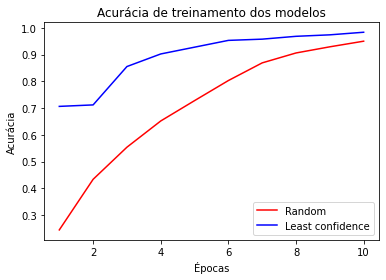

In [18]:
epochs_plot = np.arange(1, epochs + 1)

plt.plot(epochs_plot, history_1.history['accuracy'], 'r', label = 'Random')
plt.plot(epochs_plot, history_2.history['accuracy'], 'b', label = 'Least confidence')
plt.title('Acurácia de treinamento dos modelos')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()